# Evalutating Geneformer in zero-shot setting

In [ ]:
import os
import logging
import warnings
import sys

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import data, cell_embeddings, model_output
from sc_foundation_evals.helpers.custom_logging import log
log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [ ]:
geneformer_data = "model path"
# path to the pre-trained model, can work with the huggingface model hub
# i.e. ctheodoris/Geneformer
model_dir = os.path.join(geneformer_data)
# path to dictionaries in geneformer repo
dict_dir = "Pretrain_data/"

Alternatively to the code above, you can also use the snippet below, using the copy of the Genefomerme repository.

```python
repo_dir = "/path/to/repository/of/Geneformer"
model_dir = os.path.join(repo_dir)
dict_dir = os.path.join(repo_dir, "geneformer")
```

In [ ]:
# batch_size depends on available GPU memory
batch_size = 24
# output_dir is the path to which the results should be saved
output_dir = "zero_shot_results/"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(output_dir, "model_outputs")
# if you can use multithreading specify num_workers, -1 means use all available
num_workers = -1

Data paths and configs.

I will be using the Pancreas dataset as an example, as described in the scGPT_zer-shot notebook.

In [ ]:
# specify the path to anndata object
in_dataset_path = "zero_shot_batch_data/pbmc.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"zero_shot_preprocess/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "celltype" #"str_labels"
# where the raw counts are stored?
layer_key = "counts" #"X" 

## Loading model and data

In [5]:
geneform = gf.Geneformer_instance(save_dir = output_dir, 
                                  saved_model_path = model_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2025-06-21 16:11:37 | Using device cuda


In [ ]:
geneform.load_pretrained_model()

Load them vocabulary and gene to Ensembl ID matching.

In [7]:
geneform.load_vocab(dict_dir)

To prepare the data, we need to preprocess it and then tokenize it. First, we create the input data objec.

In [ ]:
input_data = data.InputData(adata_dataset_path = in_dataset_path)

Then, we preprocess the data - match gene names and filter cells and genes. This will create a new adata, that will be saved in the `preprocessed_path` to a `.loom` or `.h5ad` file. Loom data seems to be causing more issues in this version of the Geneformer code, so I'll stick with this, but overall this should also work with adata format.

In [9]:
# input_data.preprocess_data(gene_col = gene_col,
#                            model_type = "geneformer",
#                            save_ext = "loom",
#                            gene_name_id_dict = geneform.gene_name_id,
#                            preprocessed_path = preprocessed_path)

Now, tokenizing the data. Preprocessing saves the data to a file, as the tokenizer expects to read it from drive. This will create a `dataset_name`.dataset directory with the tokenized data in the `preprocessed_path`. This will also read in the tokenized_data to the `geneform` object.

In [ ]:
# geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
#                                                  f"{dataset_name}.loom"),
#                        dataset_path = preprocessed_path,
#                        cell_type_col = label_col)
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))

If the data was already tokenized, we can just load it.

```python
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))
```

## Evaluating model outputs

First, we will perform forward pass on the model and extract embeddings. We're interested with second to last layer, as per the instructions in the codebase of Geneformer [here](https://huggingface.co/ctheodoris/Geneformer/blob/main/geneformer/emb_extractor.py#L285). Using the argument `layer` we can refer to layers according to python logic (i.e. 0 is the embedding layer, 1 - first layer, 2 is the second layer, etc. and -1 is the last layer, etc.).

*Note:* If you get a CUDA out of memory error, you can try reducing the batch size. As a rule of thumb, try batch sizes of multiples of 8, to avoid potential issues with how approximations are handled in CUDA.

In [11]:
geneform.extract_embeddings(data = input_data,
                            batch_size = batch_size, 
                            layer = -2
                            # layer = -1
                            # layer = 0
                            )

Geneformer (extracting embeddings):   0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
eval_pred = model_output.GeneExprPredEval(geneform, 
                                          output_dir = model_out)

In [13]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.441406,0.588006
std,0.073241,0.193206
min,0.275004,-0.060057
25%,0.396426,0.618768
50%,0.421134,0.657667
75%,0.461914,0.689752
max,0.714837,0.799947


INFO     | 2025-06-16 14:10:58 | Subsetting to 100 cells


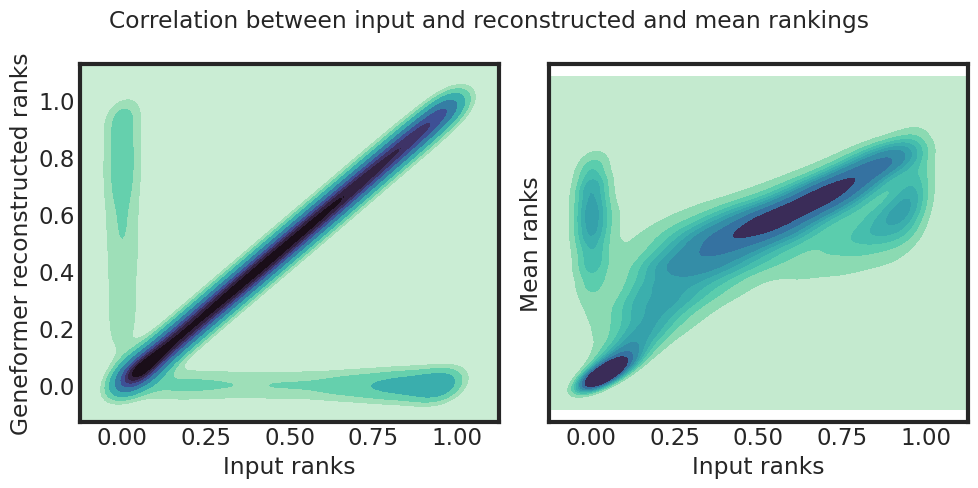

In [14]:
eval_pred.visualize(n_cells = 100, cmap = "mako_r")


In [14]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)


In [15]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 2000, embedding_key = "geneformer")

WARNING  | 2025-06-16 15:08:38 | adata_ has 329762 cells. Taking a subset of 2000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.469597
1,ARI_cluster/label,celltype,0.270278
2,ASW_label,celltype,0.462948
3,graph_conn,celltype,0.720883
4,ASW_batch,celltype,0.433283
5,ASW_label/batch,celltype,0.795673
6,PCR_batch,celltype,0.097238
7,avg_bio,celltype,0.400941


In [16]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 2000, embedding_key = "geneformer")

WARNING  | 2025-06-16 15:08:56 | adata_ has 329762 cells. Taking a subset of 2000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.469597
1,ARI_cluster/label,celltype,0.270278
2,ASW_label,celltype,0.462948
3,graph_conn,celltype,0.720883
4,ASW_batch,celltype,0.433283
5,ASW_label/batch,celltype,0.795673
6,PCR_batch,celltype,0.097238
7,avg_bio,celltype,0.400941


In [18]:
eval_ce.visualize(embedding_key = "geneformer")

In [37]:
from typing import Dict, Optional
import numpy as np
import scanpy as sc
import scib
from anndata import AnnData
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pandas as pd
import logging

log = logging.getLogger(__name__)


def eval_clustering_metrics(
    adata: AnnData,
    batch_key: Optional[str] = "str_batch",
    label_key: str = "cell_type",
    embedding_key: str = "X",  # "X" for raw, or embedding key in .obsm
    resolutions: Optional[list] = None,
    use_progress_bar: bool = True,
    verbose: bool = False,
    subsample_frac: Optional[float] = 0.25,
) -> Dict[str, float]:
    """Evaluate biological and batch mixing metrics on an embedding or raw expression."""
    
    results_dict = {}

    if subsample_frac is not None and 0 < subsample_frac < 1:
        adata = adata.copy()
        sc.pp.subsample(adata, fraction=subsample_frac, copy=False)
        if verbose:
            log.info(f"Subsampled adata to {subsample_frac * 100:.1f}% of original cells.")

    # Determine whether to use .X or .obsm[embedding_key]
    if embedding_key == "X":
        use_rep = "X"
        adata.obsm["X"] = adata.X
    elif embedding_key in adata.obsm:
        use_rep = embedding_key
    else:
        raise ValueError(f"embedding_key '{embedding_key}' not found in adata.obsm or is not 'X'")

    # Clear stale neighbors
    if "neighbors" in adata.uns:
        if verbose:
            log.warning(f"Removing stale neighbors computed from other representations.")
        adata.uns.pop("neighbors", None)

    sc.pp.neighbors(adata, use_rep=use_rep)

    # Run Louvain across multiple resolutions
    if resolutions is None:
        resolutions = [2 * i / 20 for i in range(1, 21)]  # Default: 20 steps from 0.1 to 2.0

    best_nmi = -1
    best_res = None
    best_clustering = None

    if verbose:
        log.info(f"Searching for optimal clustering resolution on {use_rep}...")

    for res in tqdm(resolutions, disable=not use_progress_bar, desc="Louvain clustering"):
        sc.tl.louvain(adata, resolution=res, key_added="temp_cluster")
        nmi = scib.metrics.nmi(adata, "temp_cluster", label_key)
        if nmi > best_nmi:
            best_nmi = nmi
            best_res = res
            best_clustering = adata.obs["temp_cluster"].copy()
        del adata.obs["temp_cluster"]

    if verbose:
        log.info(f"Best resolution: {best_res:.2f} with NMI = {best_nmi:.4f}")

    adata.obs["cluster"] = best_clustering

    # Biological conservation metrics
    results_dict["NMI_cluster/label"] = scib.metrics.nmi(adata, "cluster", label_key, "arithmetic")
    results_dict["ARI_cluster/label"] = scib.metrics.ari(adata, "cluster", label_key)
    results_dict["ASW_label"] = scib.metrics.silhouette(adata, label_key, use_rep, "euclidean")

    # Batch effect metrics (if batch_key valid)
    if batch_key is not None and batch_key in adata.obs and adata.obs[batch_key].nunique() > 1:
        adata.obs[label_key] = adata.obs[label_key].astype("category")
        results_dict["graph_conn"] = scib.metrics.graph_connectivity(adata, label_key)
        results_dict["ASW_batch"] = scib.metrics.silhouette(adata, batch_key, use_rep, "euclidean")
        results_dict["ASW_label/batch"] = scib.metrics.silhouette_batch(
            adata, batch_key, label_key, embed=use_rep, metric="euclidean", return_all=False
        )
        results_dict["PCR_batch"] = scib.metrics.pcr(
            adata, covariate=batch_key, embed=use_rep, recompute_pca=True, n_comps=50, verbose=False
        )
        results_dict["Average_Batch_Score"] = (
            results_dict["ASW_batch"] + results_dict["PCR_batch"]
        ) / 2
    else:
        if verbose:
            log.info("Skipping batch metrics — only one batch present or invalid batch_key.")
    
    results_dict["avg_bio"] = np.mean([
        results_dict["NMI_cluster/label"],
        results_dict["ARI_cluster/label"],
        results_dict["ASW_label"]
    ])

    # Filter NaNs
    results_dict = {k: v for k, v in results_dict.items() if not np.isnan(v)}

    return results_dict


In [38]:
results_dict = eval_clustering_metrics(adata=input_data.adata, 
                                        batch_key="batch",
                                        label_key="celltype",
                                        embedding_key="geneformer",  # or "X_scGPT", etc.
                                        verbose=True)
results_dict

Removing stale neighbors computed from other representations.
Louvain clustering: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


mean silhouette per group:                    silhouette_score
group                              
B cells                    0.990084
CD14+ Monocytes            0.974680
CD4 T cells                0.991498
CD8 T cells                0.993202
Dendritic Cells            0.949204
FCGR3A+ Monocytes          0.984050
Megakaryocytes             0.864510
NK cells                   0.970672
Other                      0.927177


{'NMI_cluster/label': 0.7359355202550268,
 'ARI_cluster/label': 0.799818412461634,
 'ASW_label': 0.5363253504037857,
 'graph_conn': 0.8937669240723102,
 'ASW_batch': 0.5006234394968487,
 'ASW_label/batch': 0.9605642071196792,
 'PCR_batch': 0.0007014657462978147,
 'Average_Batch_Score': 0.2506624526215733,
 'avg_bio': 0.6906930943734823}

In [39]:
results_dict_raw = eval_clustering_metrics(adata=input_data.adata, 
                                        batch_key="batch",
                                        label_key="celltype",
                                        embedding_key="X",  # or "X_scGPT", etc.
                                        verbose=True)
results_dict_raw

Removing stale neighbors computed from other representations.


Louvain clustering: 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


mean silhouette per group:                    silhouette_score
group                              
B cells                    0.971033
CD14+ Monocytes            0.942456
CD4 T cells                0.988742
CD8 T cells                0.987412
Dendritic Cells            0.938792
FCGR3A+ Monocytes          0.950513
Megakaryocytes             0.752894
NK cells                   0.890206
Other                      0.914109


{'NMI_cluster/label': 0.6505152890434263,
 'ARI_cluster/label': 0.5759899223104351,
 'ASW_label': 0.5245759263634682,
 'graph_conn': 0.8891452955038966,
 'ASW_batch': 0.4964794989209622,
 'ASW_label/batch': 0.9262396008669715,
 'PCR_batch': 0.0007824623021499673,
 'Average_Batch_Score': 0.24863098061155608,
 'avg_bio': 0.5836937125724432}

In [34]:
results_dict

{'NMI_cluster/label': 0.7102011123975458,
 'ARI_cluster/label': 0.6477001468186342,
 'ASW_label': 0.5428623855113983,
 'graph_conn': 0.912028584635897,
 'ASW_batch': 0.5018822988495231,
 'ASW_label/batch': 0.9549707840228508,
 'PCR_batch': 0.001357968419881124,
 'avg_bio': 0.6335878815758594}

Layer = -1
BertCAB 25
30M Models

WARNING  | 2025-06-10 15:20:08 | Copying existing UMAP embedding to X_umap_old and overwriting X_umap.
WARNING  | 2025-06-10 15:20:19 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2025-06-10 15:20:19 | More than 10 labels for celltype.The plots might be hard to read.


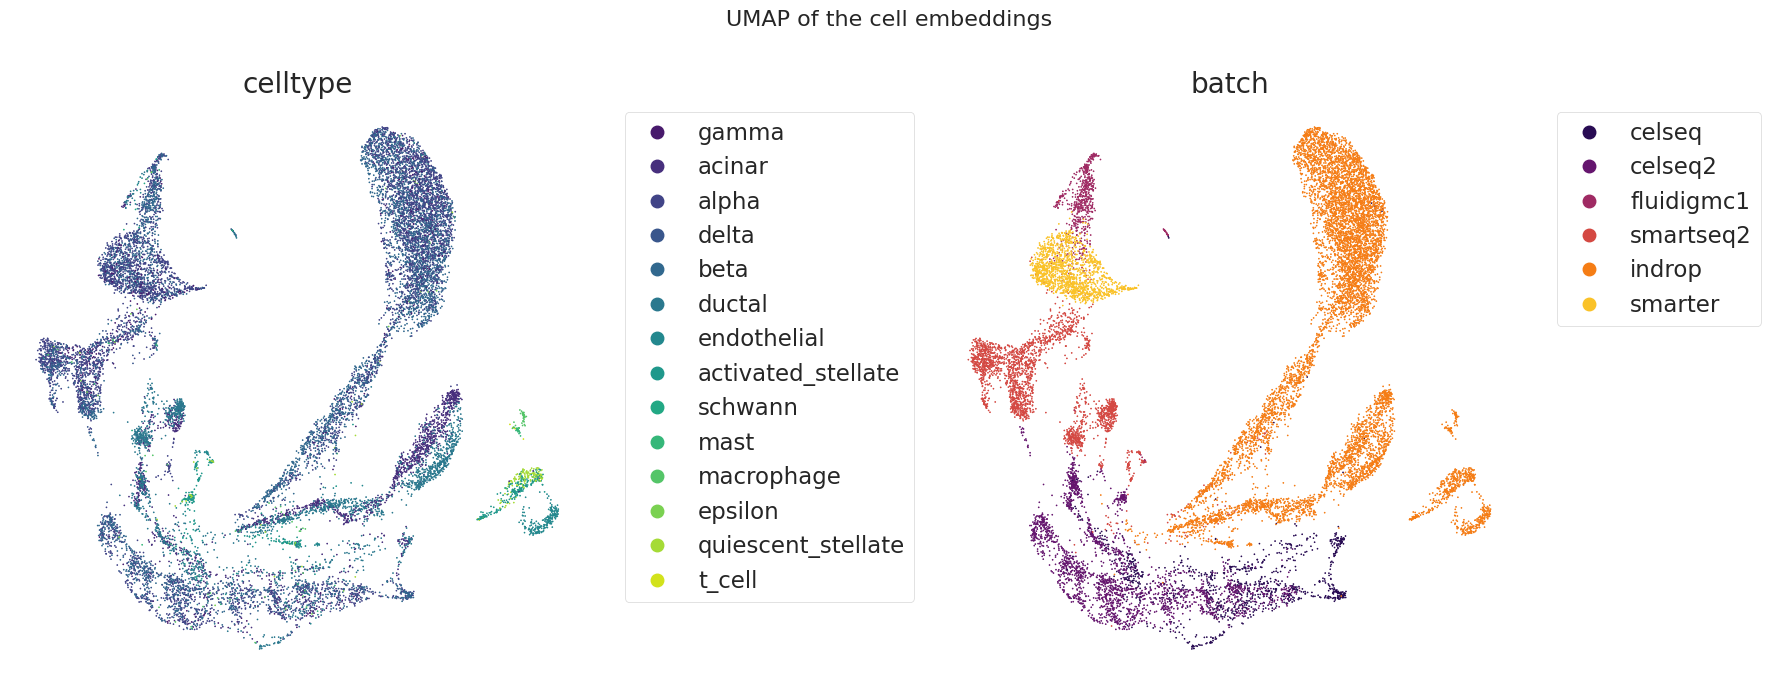

In [39]:
eval_ce.visualize(embedding_key = "geneformer")

GF 30M re-trained from scratch
layer = -2

WARNING  | 2025-06-10 13:50:03 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2025-06-10 13:50:03 | More than 10 labels for celltype.The plots might be hard to read.


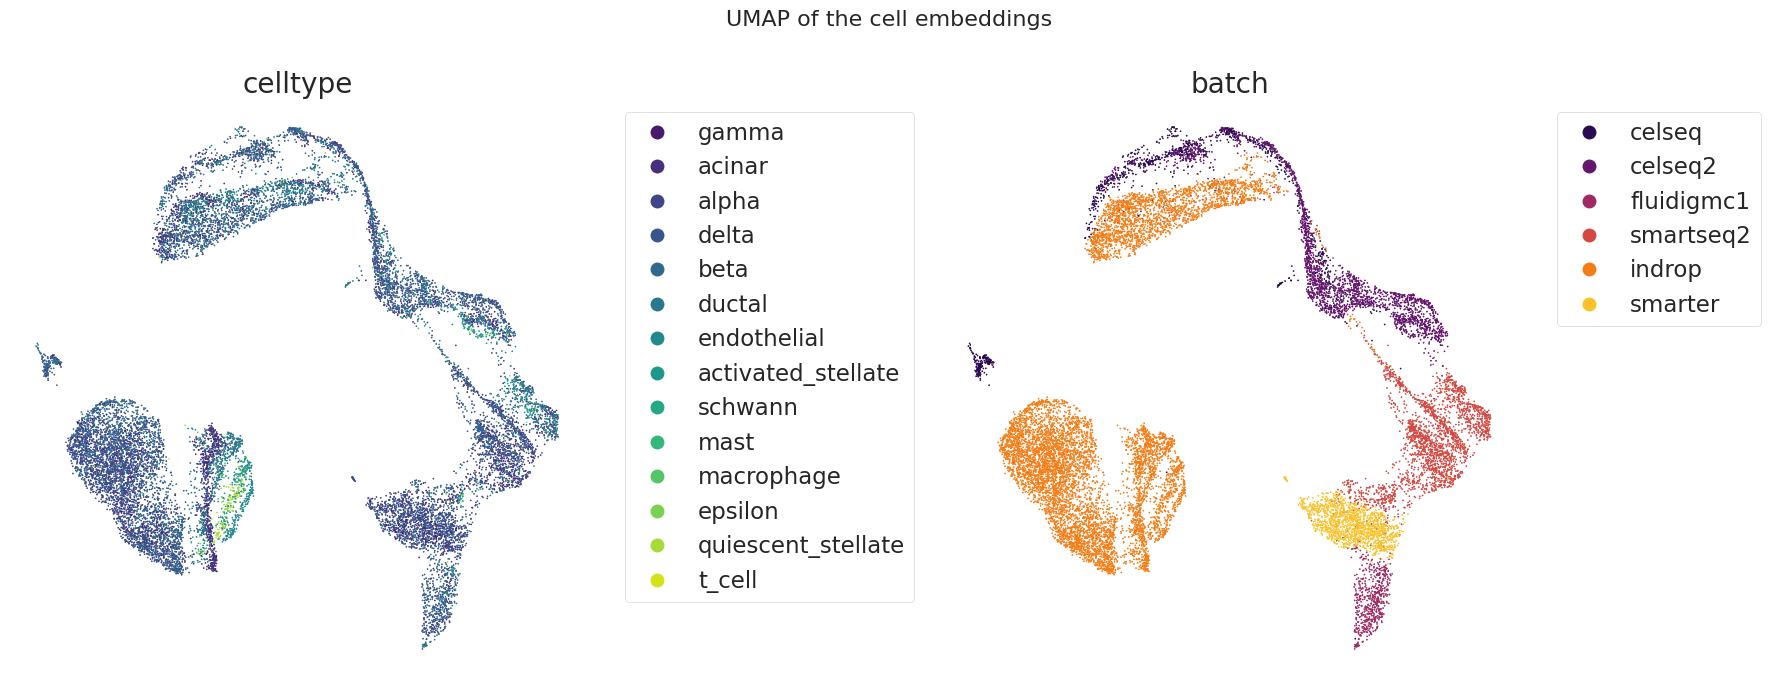

In [20]:
eval_ce.visualize(embedding_key = "geneformer")

# Original Reported Results

In [13]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.571496,0.661472
std,0.112216,0.112700
min,0.238710,0.401928
25%,0.487676,0.548921
50%,0.563608,0.719794
75%,0.667890,0.757058
max,0.815732,0.809235


INFO     | 2023-12-05 15:07:41 | Subsetting to 100 cells


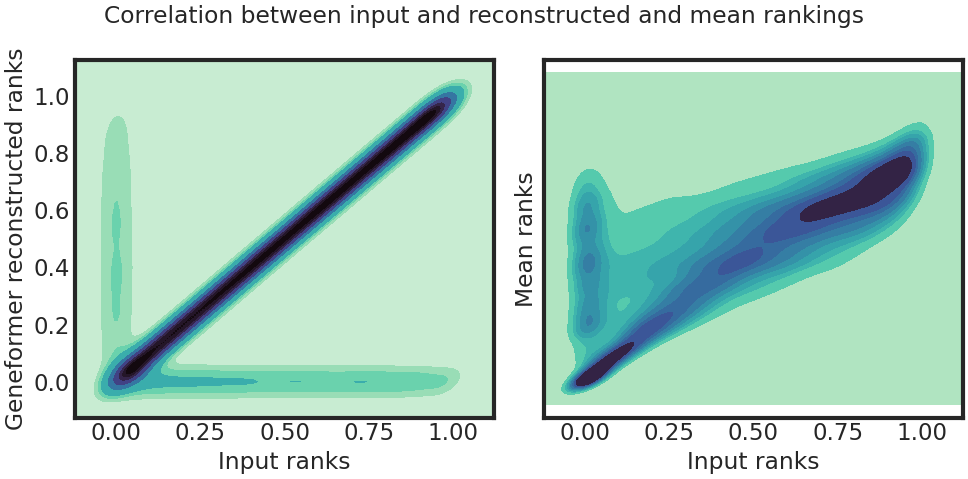

In [14]:
eval_pred.visualize(n_cells = 100, cmap = "mako_r")

# Evaluate the cell embeddings

First, creating cell embeddings evaluation object.

In [15]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)


Then, evaluating the embeddings. Here, for speed we are subsetting the data to 1000 cells.

In [16]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2023-12-05 15:13:20 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.091457
1,ARI_cluster/label,celltype,0.023780
2,ASW_label,celltype,0.323220
3,graph_conn,celltype,0.476560
4,ASW_batch,celltype,0.622801
5,ASW_label/batch,celltype,0.676177
6,PCR_batch,celltype,0.632914
7,avg_bio,celltype,0.146152


In [17]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2023-12-05 15:13:28 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.091457
1,ARI_cluster/label,celltype,0.023780
2,ASW_label,celltype,0.323220
3,graph_conn,celltype,0.476560
4,ASW_batch,celltype,0.622801
5,ASW_label/batch,celltype,0.676177
6,PCR_batch,celltype,0.632914
7,avg_bio,celltype,0.146152


WARNING  | 2023-12-05 15:14:52 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2023-12-05 15:14:53 | More than 10 labels for celltype.The plots might be hard to read.


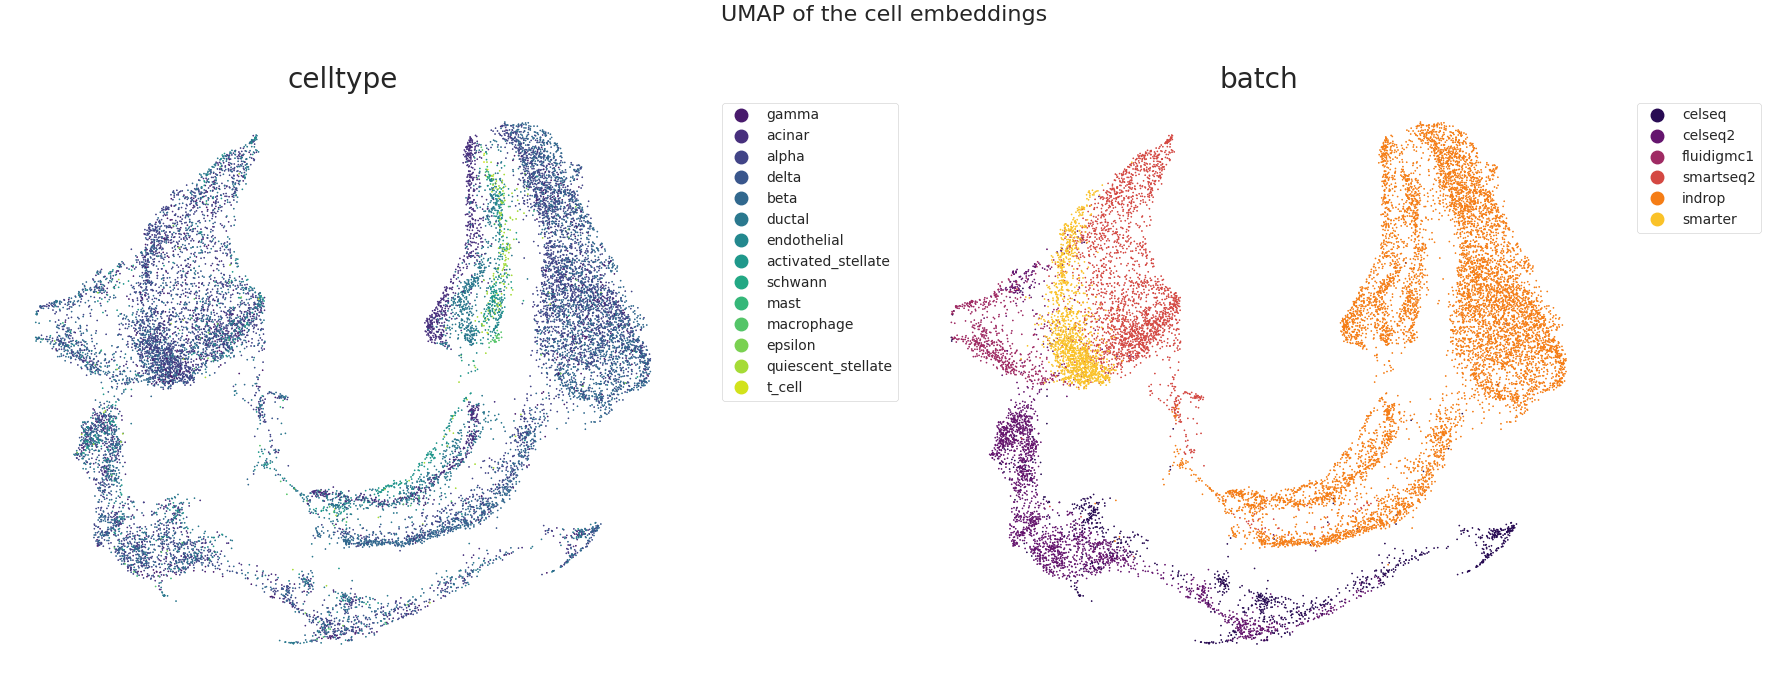

In [18]:
eval_ce.visualize(embedding_key = "geneformer")

bertcab10 1M
{'NMI_cluster/label': 0.550067742123904,
    'ARI_cluster/label': 0.2844253502648678,
    'ASW_label': 0.497075610794127,
    'graph_conn': 0.8462051187718054,
    'ASW_batch': 0.4679742865264416,
    'ASW_label/batch': 0.8438504014519913,
    'PCR_batch': 0.11005443461431771,
    'Average_Batch_Score': 0.28901436057037966,
    'avg_bio': 0.4438562343942996}

raw


hvg
{'NMI_cluster/label': 0.6519618825284081, 
    'ARI_cluster/label': 0.382739455731563, 
    'ASW_label': 0.5102478610351682, 
    'graph_conn': 0.9159615962052413, 
    'ASW_batch': 0.5001192105482914, 
    'ASW_label/batch': 0.9501239357502514, 
    'PCR_batch': 0.13615515236009157, 
    'Average_Batch_Score': 0.3181371814541915, 
    'avg_bio': 0.5149830664317131}  


scvi